### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
import keras as ks
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
import shap
import tensorflow as tf

tf.compat.v1.Session()

shap.initjs()



%matplotlib inline
class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

seed = 0

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  depreca

In [2]:
print(ks.__version__)
print(tf.__version__)


infile = open("../../tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)

2.2.5
1.14.0


### Read in a dataset file

In [3]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [4]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        row.append(val)    
    return row

In [5]:
#def metricName(index):

### Clean data row
Not implemented

In [6]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

### Get dataset
Loads all files from a directory

In [7]:
packet_count_threshold = 200
def get_dataset(path):
    out_data = []
    file = open('summary.out', 'w')
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = np.nan_to_num(read_in_file(temp_path))
            rows_before = temp_data.shape[0]
            if rows_before == 0:
                continue
            temp_data = temp_data[temp_data[:,2] > packet_count_threshold]
            rows_after = temp_data.shape[0]
            print (path + " removed " + str(rows_before-rows_after) + "/" + str(rows_before) + " rows")
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    file.close
    return out_data

### Load DTN datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [8]:
dtn_normal = get_dataset("../../DataSet/dtn/FINAL_DATA/normal")
dtn_normal2 = get_dataset("../../DataSet/dtn/DTN_LONG_DATA/normal")
dtn_corr_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc")
dtn_corr_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc")
dtn_corr_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc")
dtn_delay_1_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_1_var_1")
dtn_delay_5_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_5_var_2")
dtn_delay_10_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_10_var_5")
dtn_delay_25_20 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_25_var_20")
dtn_drop_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_1perc")
dtn_drop_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_5perc")
dtn_drop_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_10perc")
dtn_drop_15 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_15perc")
dtn_dup_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_0.1perc")
dtn_dup_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_1perc")
dtn_dup_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_2perc")

dtn_corrupt_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.01")
dtn_corrupt_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.05")
dtn_corrupt_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1")
dtn_corrupt_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5")
dtn_duplicate_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.01")
dtn_duplicate_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.05")
dtn_duplicate_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.1")
dtn_duplicate_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.5")
dtn_loss_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.01")
dtn_loss_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.05")
dtn_loss_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.1")
dtn_loss_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.5")


l1  = np.ones(len(dtn_normal  ) + len(dtn_normal2)) *1
l2  = np.ones(len(dtn_corr_01  ))   *2
l3  = np.ones(len(dtn_corr_05  ))   *2
l4  = np.ones(len(dtn_corr_10  ))   *2
l5  = np.ones(len(dtn_corrupt_001  ))  *2
l6  = np.ones(len(dtn_corrupt_005  ))  *2
l7  = np.ones(len(dtn_corrupt_01  ))   *2
l8  = np.ones(len(dtn_corrupt_05  ))   *2
l9  = np.ones(len(dtn_delay_1_1))   *3
l10  = np.ones(len(dtn_delay_5_2))   *3
l11  = np.ones(len(dtn_delay_10_5))  *3
l12  = np.ones(len(dtn_delay_25_20)) *3
l13  = np.ones(len(dtn_drop_01 ) ) *4
l14  = np.ones(len(dtn_drop_5) )   *4
l15  = np.ones(len(dtn_drop_10) )  *4
l16 = np.ones(len(dtn_drop_15) )   *4
l17  = np.ones(len(dtn_loss_001))  *4
l18  = np.ones(len(dtn_loss_005))  *4
l19  = np.ones(len(dtn_loss_01))   *4
l20  = np.ones(len(dtn_loss_05))   *4
l21  = np.ones(len(dtn_dup_01))    *5
l22  = np.ones(len(dtn_dup_1))     *5
l23  = np.ones(len(dtn_dup_2))     *5
l24  = np.ones(len(dtn_duplicate_001)) *5
l25  = np.ones(len(dtn_duplicate_005))*5
l26  = np.ones(len(dtn_duplicate_01)) *5
l27  = np.ones(len(dtn_duplicate_05)) *5


dtn_data = np.concatenate((dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10,
                           dtn_corrupt_001, dtn_corrupt_005, dtn_corrupt_01, dtn_corrupt_05, 
                           dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           dtn_drop_01, dtn_drop_5, dtn_drop_10, dtn_drop_15, dtn_loss_001,
                           dtn_loss_005, dtn_loss_01, dtn_loss_05,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2,dtn_duplicate_001,
                           dtn_duplicate_005, dtn_duplicate_01, dtn_duplicate_05,))


dtn_data = MinMaxScaler().fit_transform(dtn_data)


pandas_dtn = pd.DataFrame(data=dtn_data, 
              columns=data_field_labels)


dtn_anom_type_data_labels = np.concatenate((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14,l15,
                                           l16, l17, l18, l19, l20, l21,l22, l23, l24,l25,l26,l27))
dtn_anom_type_data_labels = pd.DataFrame(data=dtn_anom_type_data_labels)
dtn_anom_type_data_labels = dtn_anom_type_data_labels.values.ravel()
pandas_dtn_label =  pd.DataFrame(data=dtn_anom_type_data_labels, 
              columns=["labels"])

print(pandas_dtn_label)



../../DataSet/dtn/FINAL_DATA/normal removed 103/103 rows
../../DataSet/dtn/FINAL_DATA/normal removed 112/224 rows
../../DataSet/dtn/FINAL_DATA/normal removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/normal removed 11/22 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 353/706 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 354/708 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 354/708 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 18/36 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/delay_1_var_1 removed 7/13 rows
../../DataSet/dtn/FINAL_DATA/delay_1_var_1 removed 15/26 rows
../../DataSet/dtn/FINAL_DATA/de

elementwise comparison failed; this will raise an error in the future.


../../DataSet/dtn/FINAL_DATA/loss_1perc removed 119/238 rows
../../DataSet/dtn/FINAL_DATA/loss_5perc removed 62/91 rows
../../DataSet/dtn/FINAL_DATA/loss_5perc removed 118/208 rows
../../DataSet/dtn/FINAL_DATA/loss_10perc removed 117/191 rows
../../DataSet/dtn/FINAL_DATA/loss_15perc removed 115/183 rows
../../DataSet/dtn/FINAL_DATA/dup_0.1perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/dup_0.1perc removed 11/22 rows
../../DataSet/dtn/FINAL_DATA/dup_1perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/dup_1perc removed 11/22 rows
../../DataSet/dtn/FINAL_DATA/dup_2perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/dup_2perc removed 11/22 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.01 removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.05 removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1 removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5 removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/duplicate_0.01 removed 120/240 rows
../../DataSet/dtn/FINAL_DATA

### Split Datasets (randomized on seed value)



In [9]:
print(type(pandas_dtn))
print(type(pandas_dtn_label))
dtn_train_data, dtn_test_data, dtn_train_labels, dtn_test_labels = train_test_split(pandas_dtn, 
                                                                   pandas_dtn_label, random_state=seed)
dtn_train_data, dtn_train_labels = SMOTE().fit_resample(dtn_train_data, dtn_train_labels)

dtn_train_data = pd.DataFrame(data=dtn_train_data, 
              columns=data_field_labels)

dtn_train_labels = pd.DataFrame(data=dtn_train_labels,
              columns=["labels"])




#print(type(c))
#print(type(dtn_train_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


## DT:

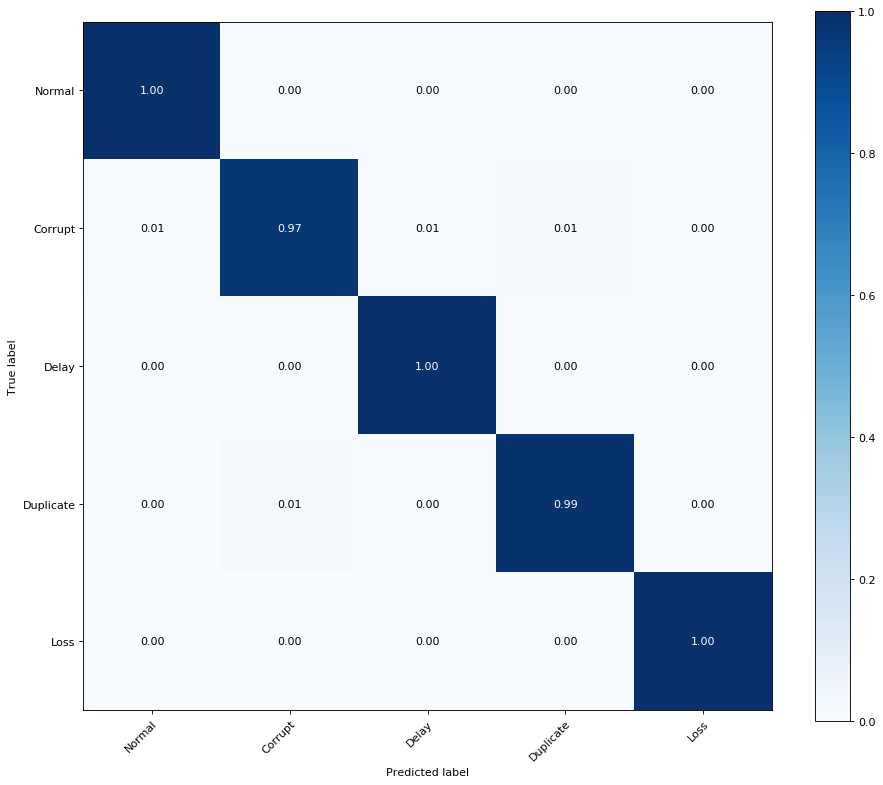

In [10]:
dtn =  DecisionTreeClassifier()
dtn.fit(dtn_train_data, dtn_train_labels)
dtn_predicted_labels = dtn.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_DT_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_DT.pdf')
plt.show()





In [11]:
explainer = shap.TreeExplainer(dtn)
shap_values = explainer.shap_values(dtn_train_data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


(4500, 89)


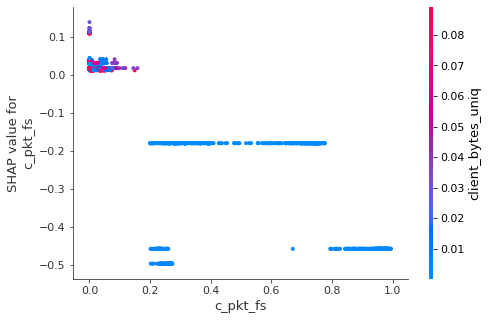

In [12]:
print(dtn_train_data.shape)
#shap.dependence_plot("c_pkt_fs", shap_values[0], dtn_train_data)

shap.dependence_plot("c_pkt_fs", shap_values[0], dtn_train_data)

## Shap

In [13]:


## visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0]
                , shap_values[0]
                , dtn_train_data)


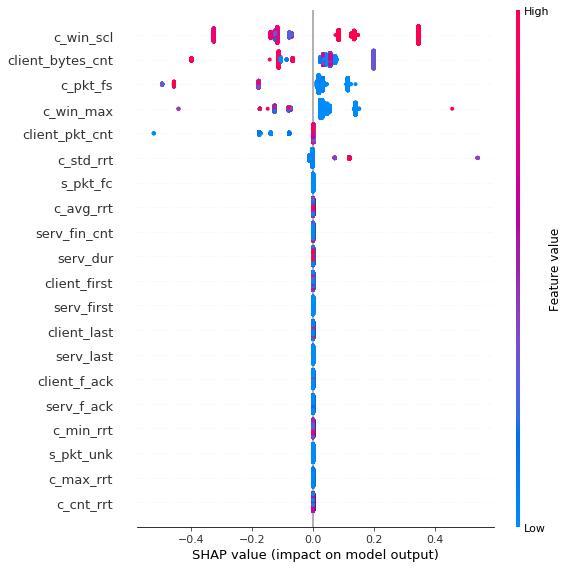

In [14]:
shap.summary_plot(shap_values[0], dtn_train_data,plot_type = "dot")

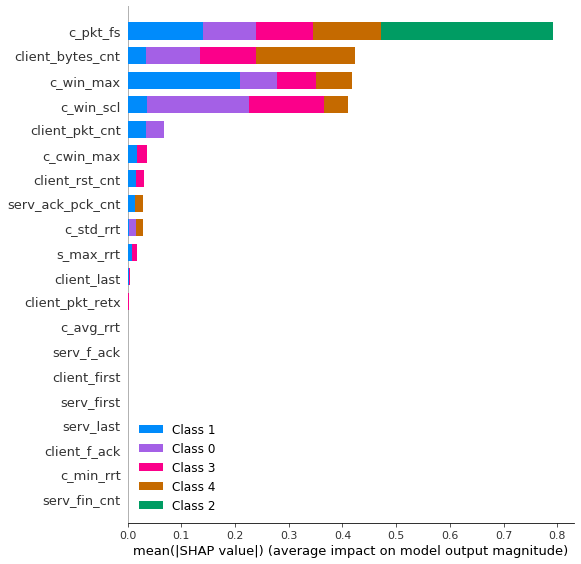

In [15]:
shap.summary_plot(shap_values, dtn_train_data)

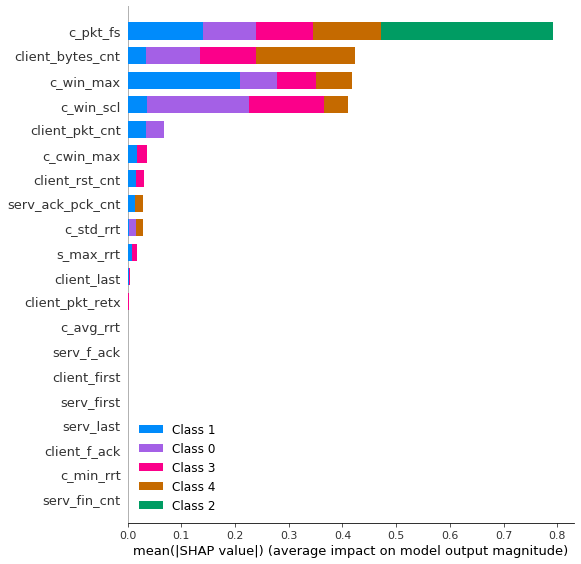

In [16]:
shap.summary_plot(shap_values, dtn_train_data)

## RF :

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


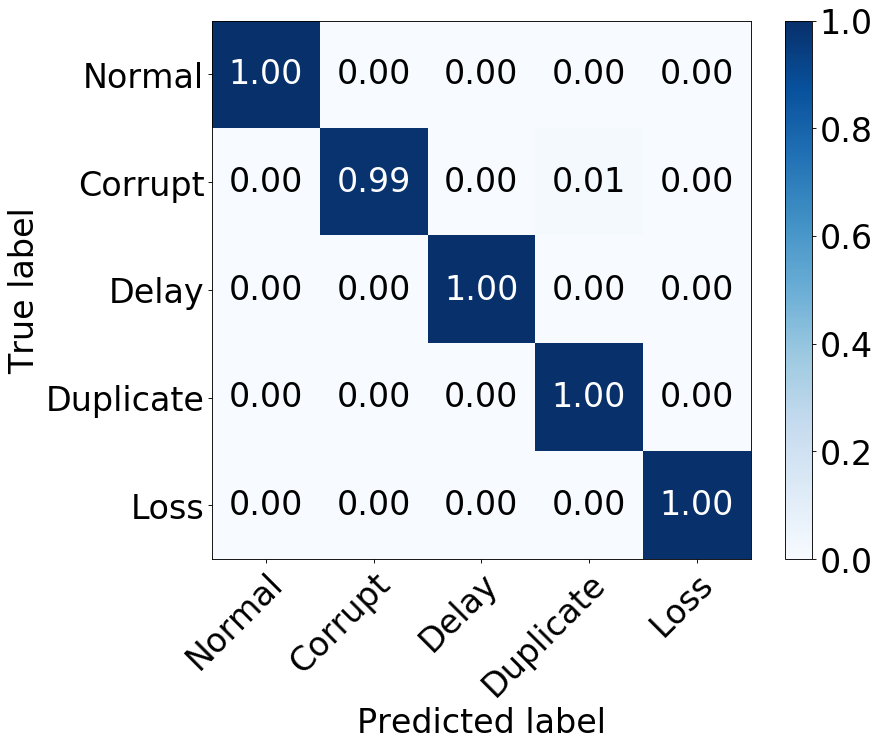

In [17]:
dtn =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
dtn.fit(dtn_train_data, dtn_train_labels)
dtn_predicted_labels = dtn.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_RF_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_RF.pdf')
plt.show()


## SVM :

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


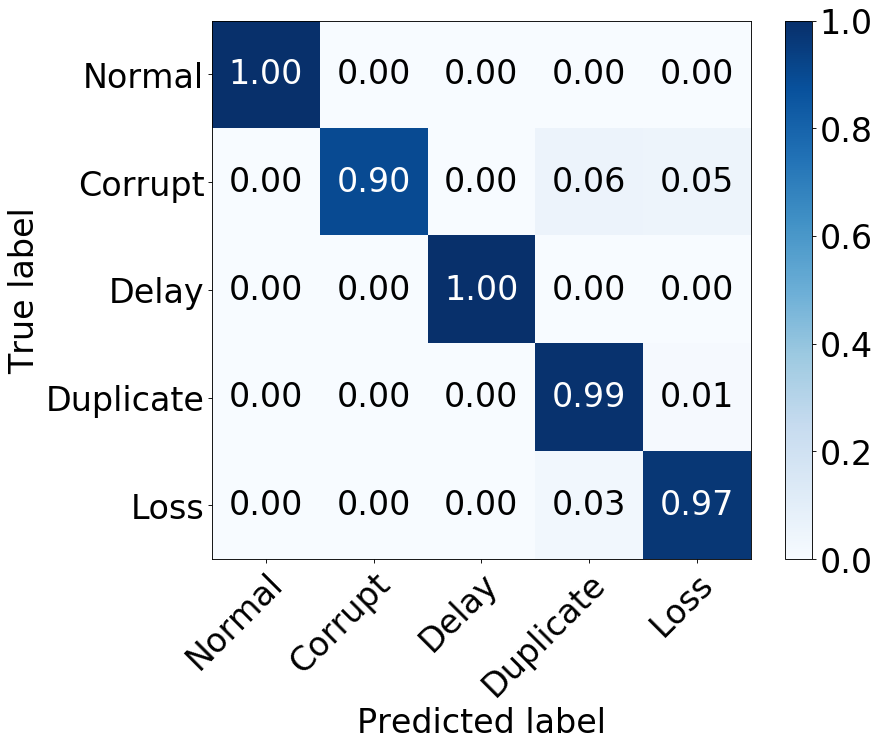

In [18]:
dtn = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
dtn.fit(dtn_train_data, dtn_train_labels)
dtn_predicted_labels = dtn.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_SVM_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_SVM.pdf')
plt.show()

## NN :





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3600 samples, validate on 900 samples
Epoch 1/10
3600/3600 [==============================] - 1s 172us/step - loss: 0.5994 - acc: 0.7814 - val_loss: 0.3319 - val_acc: 0.8922
Epoch 2/10
3600/3600 [==============================] - 0s 110us/step - loss: 0.1943 - acc: 0.9358 - val_loss: 0.1974 - val_acc: 0.9133
Epoch 3/10
3600/3600 [==============================] - 0s 120us/step - loss: 0.1151 - acc: 0.9664 - val_loss: 0.1011 - val_acc: 0.9833
Epoch 4/10
3600/3600 [==============================] - 0s 76us/step - loss: 0.0922 - acc: 0.9722 - val_loss: 0.0961 - val_acc: 0.9844
Epoch 5/10
3600/3600 [==============================] - 0s 69us/step - loss: 0.0639 - acc: 0.9853 - val_loss: 0.0873 - val_acc: 0.9811
Epoch 6/10
3600/3600 [==============================] - 0s 8

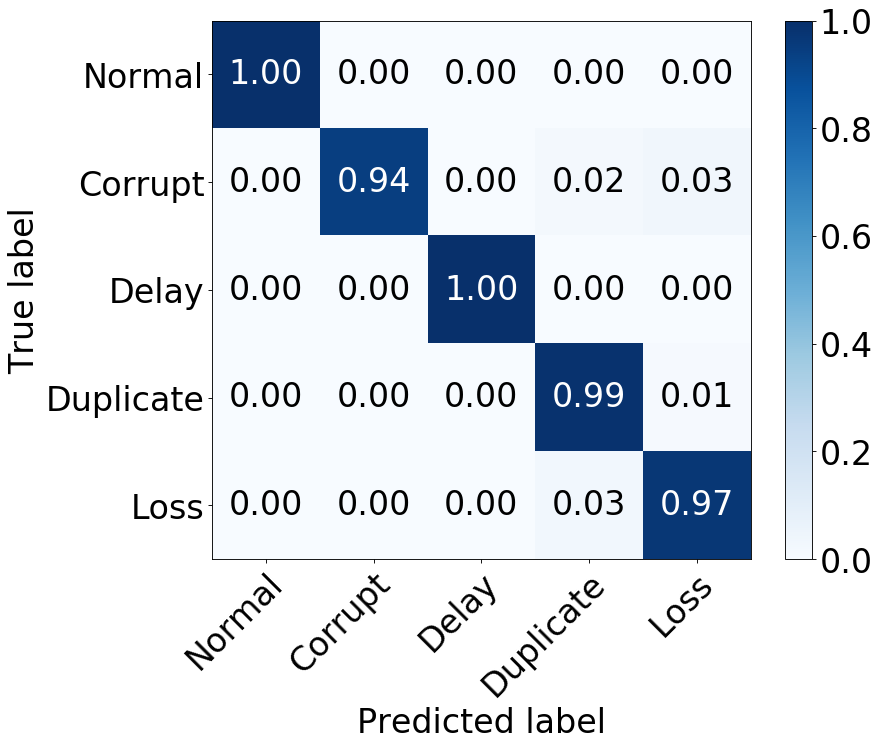

In [19]:
#create model
model = Sequential()

#get number of columns in training data
n_cols = dtn_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

dtn_train_labels = to_categorical(dtn_train_labels)

model.fit(dtn_train_data, dtn_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
plot_confusion_matrix(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_NN.pdf')
plt.show()


In [20]:
print(shap.__version__)
print(pd.__version__)


df_train_normed_summary = shap.kmeans(dtn_train_data.values, 25)

explainer = shap.KernelExplainer(model.predict,df_train_normed_summary)
shap_values = explainer.shap_values(dtn_train_data)


0.34.0
1.0.0


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values[0], dtn_train_data)